## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-19 22:32:04.936217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 22:32:04.936285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

"""
experiment permutation
"""
Dropout_EXP = [0.1, 0.2, 0.4]
LAYER_NEURONS = [[128, 128, 128], [128, 256, 256], [128, 256, 512]]

In [17]:
import itertools

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (layer_neurons, drp_rate) in enumerate(itertools.product(LAYER_NEURONS, Dropout_EXP)):
    print("Number of exp %i, layer: %s, dropout_rate: %.2f" %(i, layer_neurons, drp_rate))
    model = build_mlp(input_shape = x_train.shape[1:], num_neurons=layer_neurons, drp_ratio=drp_rate)
    model.summary()
    
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(x_test, y_test),
             verbose=0,
             shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    
    exp_name_tag = (f"Layer_neurons:{layer_neurons}, Dropout ratio: {drp_rate}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}    
    

Number of exp 0, layer: [128, 128, 128], dropout_rate: 0.10
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_108 (Dropout)        (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_109 (Dropout)        (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               16512     
________________________________________________________________

Number of exp 6, layer: [128, 256, 512], dropout_rate: 0.10
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_126 (Dropout)        (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               33024     
_________________________________________________________________
dropout_127 (Dropout)        (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               131584    
________________________________________________________________

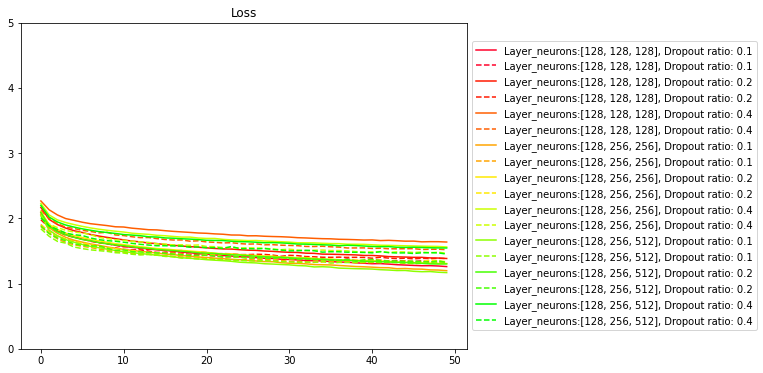

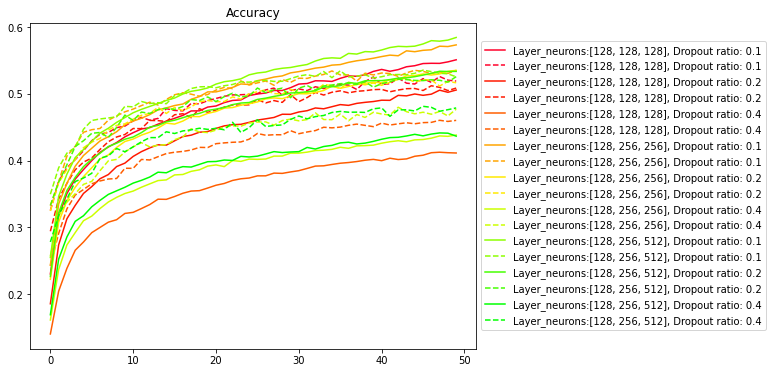

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [ scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
"""Code Here
將結果繪出
"""

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()